# Collaborative Filtering - Système de Recommandation

Implémentation de 3 algorithmes de filtrage collaboratif pour la recommandation d'articles

In [1]:
import pandas as pd
import numpy as np
import pickle
import glob
from datetime import datetime
from scipy.sparse import csr_matrix, lil_matrix
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Bibliothèques de collaborative filtering
from surprise import SVD, NMF, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_split
import implicit
from implicit.als import AlternatingLeastSquares

## 1. Chargement et Préparation des Données

In [2]:
# Chargement des métadonnées
articles_df = pd.read_csv('data/articles_metadata.csv')
articles_df = articles_df.drop_duplicates(subset=['article_id'])
articles_df = articles_df[(articles_df['words_count'] >= 10) & (articles_df['words_count'] <= 2000)]

# Chargement des clics
click_files = sorted(glob.glob('data/clicks/clicks_hour_*.csv'))[:150]
clicks_df = pd.concat([pd.read_csv(f) for f in click_files], ignore_index=True)

# Nettoyage
clicks_df = clicks_df.drop_duplicates()
clicks_df = clicks_df[clicks_df['session_size'] <= 200]
valid_articles = set(articles_df['article_id'].unique())
clicks_df = clicks_df[clicks_df['click_article_id'].isin(valid_articles)]

# Calcul du temps jusqu'au clic
clicks_df['time_to_click'] = (clicks_df['click_timestamp'] - clicks_df['session_start']) / 1000
clicks_df = clicks_df[(clicks_df['time_to_click'] >= 0) & (clicks_df['time_to_click'] <= 3600)]

print(f"Articles: {len(articles_df):,}")
print(f"Clics: {len(clicks_df):,}")
print(f"Utilisateurs uniques: {clicks_df['user_id'].nunique():,}")
print(f"Articles cliqués: {clicks_df['click_article_id'].nunique():,}")

Articles: 363,946
Clics: 1,191,879
Utilisateurs uniques: 210,991
Articles cliqués: 20,793


## 2. Création des Matrices d'Interaction

In [3]:
# Agrégation des interactions
interactions = clicks_df.groupby(['user_id', 'click_article_id']).agg({
    'click_timestamp': 'count',
    'time_to_click': 'mean'
}).reset_index()
interactions.columns = ['user_id', 'article_id', 'click_count', 'avg_time_to_click']

# Score d'engagement pondéré
max_time = interactions['avg_time_to_click'].max()
interactions['engagement_score'] = interactions['click_count'] * (1 - interactions['avg_time_to_click'] / max_time)
interactions['rating'] = 1 + 4 * (interactions['engagement_score'] - interactions['engagement_score'].min()) / \
                        (interactions['engagement_score'].max() - interactions['engagement_score'].min())

# Filtrage des utilisateurs actifs
user_counts = interactions['user_id'].value_counts()
active_users = user_counts[user_counts >= 5].index
filtered_interactions = interactions[interactions['user_id'].isin(active_users)]

# Création des mappings
unique_users = sorted(filtered_interactions['user_id'].unique())
unique_items = sorted(filtered_interactions['article_id'].unique())
user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
item_to_idx = {item: idx for idx, item in enumerate(unique_items)}

filtered_interactions['user_idx'] = filtered_interactions['user_id'].map(user_to_idx)
filtered_interactions['item_idx'] = filtered_interactions['article_id'].map(item_to_idx)

print(f"\nInteractions filtrées: {len(filtered_interactions):,}")
print(f"Rating moyen: {filtered_interactions['rating'].mean():.2f}")
print(f"Sparsité: {1 - len(filtered_interactions) / (len(unique_users) * len(unique_items)):.2%}")


Interactions filtrées: 839,084
Rating moyen: 1.23
Sparsité: 99.93%


## 3. Split Train/Test Temporel

In [4]:
def temporal_split(interactions_df, test_ratio=0.2, min_test_interactions=2):
    """Split temporel garantissant des items prédictibles dans le test"""
    train_data, test_data = [], []
    
    for user_id, user_interactions in interactions_df.groupby('user_id'):
        user_sorted = user_interactions.sort_index()
        n_interactions = len(user_sorted)
        
        if n_interactions >= min_test_interactions + 2:
            split_point = int(n_interactions * (1 - test_ratio))
            split_point = max(2, min(split_point, n_interactions - min_test_interactions))
            
            train_data.append(user_sorted.iloc[:split_point])
            test_data.append(user_sorted.iloc[split_point:])
        else:
            train_data.append(user_sorted)
    
    train_df = pd.concat(train_data, ignore_index=True)
    test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame()
    
    # Filtrer le test pour ne garder que les articles du train
    train_items = set(train_df['article_id'].unique())
    test_df = test_df[test_df['article_id'].isin(train_items)]
    
    return train_df, test_df

train_df, test_df = temporal_split(filtered_interactions, test_ratio=0.2)

print(f"Train: {len(train_df):,} interactions")
print(f"Test: {len(test_df):,} interactions")
print(f"Utilisateurs dans test: {test_df['user_id'].nunique():,}")
print(f"Articles testables: {len(set(test_df['article_id']) & set(train_df['article_id'])):,}")

Train: 625,439 interactions
Test: 208,396 interactions
Utilisateurs dans test: 78,646
Articles testables: 3,603


## 4. Approche 1: SVD (Singular Value Decomposition)

In [5]:
class SVDRecommender:
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        self.model = SVD(
            n_factors=n_factors,
            n_epochs=n_epochs,
            lr_all=lr_all,
            reg_all=reg_all,
            verbose=False
        )
        self.is_trained = False
        
    def fit(self, train_df):
        """Entraînement du modèle SVD"""
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(
            train_df[['user_id', 'article_id', 'rating']], 
            reader
        )
        self.trainset = data.build_full_trainset()
        self.model.fit(self.trainset)
        self.is_trained = True
        
        # Stocker les informations importantes
        self.user_items = train_df.groupby('user_id')['article_id'].apply(set).to_dict()
        self.all_items = set(train_df['article_id'].unique())
        self.item_popularity = train_df['article_id'].value_counts().to_dict()
    
    def recommend(self, user_id, n=10, exclude_seen=True):
        """Génère n recommandations pour un utilisateur"""
        if not self.is_trained:
            return []
        
        seen_items = self.user_items.get(user_id, set()) if exclude_seen else set()
        
        try:
            self.trainset.to_inner_uid(user_id)
            user_known = True
        except ValueError:
            user_known = False
        
        candidates = list(self.all_items - seen_items)
        
        if not candidates:
            return []
        
        # Limiter pour performance
        if len(candidates) > 500:
            popular = sorted(candidates, key=lambda x: self.item_popularity.get(x, 0), reverse=True)[:250]
            random = list(np.random.choice(
                [c for c in candidates if c not in popular], 
                min(250, len(candidates)-250), replace=False
            ))
            candidates = popular + random
        
        predictions = []
        for item_id in candidates:
            try:
                self.trainset.to_inner_iid(item_id)
                item_known = True
            except ValueError:
                item_known = False
            
            if user_known and item_known:
                pred = self.model.predict(user_id, item_id)
                predictions.append((item_id, pred.est))
            elif item_known:
                item_inner_id = self.trainset.to_inner_iid(item_id)
                item_bias = self.model.bi[item_inner_id] if hasattr(self.model, 'bi') else 0
                predictions.append((item_id, self.trainset.global_mean + item_bias))
            else:
                popularity_score = self.item_popularity.get(item_id, 0) / max(self.item_popularity.values())
                predictions.append((item_id, self.trainset.global_mean * (0.5 + 0.5 * popularity_score)))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in predictions[:n]]

## 5. Approche 2: NMF (Non-Negative Matrix Factorization)

In [6]:
class NMFRecommender:
    def __init__(self, n_factors=50, n_epochs=50):
        self.model = NMF(
            n_factors=n_factors,
            n_epochs=n_epochs,
            verbose=False
        )
        self.is_trained = False
        
    def fit(self, train_df):
        """Entraînement du modèle NMF"""
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(
            train_df[['user_id', 'article_id', 'rating']], 
            reader
        )
        self.trainset = data.build_full_trainset()
        self.model.fit(self.trainset)
        self.is_trained = True
        
        self.user_items = train_df.groupby('user_id')['article_id'].apply(set).to_dict()
        self.all_items = set(train_df['article_id'].unique())
        self.item_popularity = train_df['article_id'].value_counts().to_dict()
    
    def recommend(self, user_id, n=10, exclude_seen=True):
        """Génère n recommandations pour un utilisateur"""
        if not self.is_trained:
            return []
        
        seen_items = self.user_items.get(user_id, set()) if exclude_seen else set()
        
        try:
            self.trainset.to_inner_uid(user_id)
            user_known = True
        except ValueError:
            user_known = False
        
        candidates = list(self.all_items - seen_items)
        
        if not candidates:
            return []
        
        if len(candidates) > 500:
            popular = sorted(candidates, key=lambda x: self.item_popularity.get(x, 0), reverse=True)[:250]
            random = list(np.random.choice(
                [c for c in candidates if c not in popular], 
                min(250, len(candidates)-250), replace=False
            ))
            candidates = popular + random
        
        predictions = []
        for item_id in candidates:
            try:
                self.trainset.to_inner_iid(item_id)
                item_known = True
            except ValueError:
                item_known = False
            
            if user_known and item_known:
                pred = self.model.predict(user_id, item_id)
                predictions.append((item_id, pred.est))
            elif item_known:
                item_inner_id = self.trainset.to_inner_iid(item_id)
                item_ratings = [self.trainset.ur[u][1] for u in range(self.trainset.n_users) 
                              if item_inner_id in [i for i, r in self.trainset.ur[u]]]
                item_mean = np.mean(item_ratings) if item_ratings else self.trainset.global_mean
                predictions.append((item_id, item_mean))
            else:
                popularity_score = self.item_popularity.get(item_id, 0) / max(self.item_popularity.values())
                predictions.append((item_id, self.trainset.global_mean * (0.5 + 0.5 * popularity_score)))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in predictions[:n]]

## 6. Approche 3: ALS (Alternating Least Squares)

In [7]:
class ALSRecommender:
    def __init__(self, factors=100, regularization=0.01, iterations=20, alpha=40):
        self.model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            alpha=alpha,
            random_state=42
        )
        self.is_trained = False
        
    def fit(self, train_df):
        """Entraînement du modèle ALS"""
        # Créer la matrice sparse user-item
        n_users = train_df['user_idx'].max() + 1
        n_items = train_df['item_idx'].max() + 1
        
        self.user_item_matrix = lil_matrix((n_users, n_items))
        
        for _, row in train_df.iterrows():
            self.user_item_matrix[row['user_idx'], row['item_idx']] = row['click_count']
        
        self.user_item_matrix = self.user_item_matrix.tocsr()
        self.item_user_matrix = self.user_item_matrix.T.tocsr()
        
        # Entraînement
        self.model.fit(self.item_user_matrix)
        self.is_trained = True
        
        # Stocker les mappings
        self.user_to_idx = train_df[['user_id', 'user_idx']].drop_duplicates().set_index('user_id')['user_idx'].to_dict()
        self.item_to_idx = train_df[['article_id', 'item_idx']].drop_duplicates().set_index('article_id')['item_idx'].to_dict()
        self.idx_to_item = {v: k for k, v in self.item_to_idx.items()}
        self.user_items = train_df.groupby('user_id')['article_id'].apply(set).to_dict()
        self.item_popularity = train_df['article_id'].value_counts().to_dict()
        self.all_items = set(train_df['article_id'].unique())
    
    def recommend(self, user_id, n=10, exclude_seen=True):
        """Génère n recommandations pour un utilisateur"""
        if not self.is_trained:
            return []
        
        # Si l'utilisateur n'est pas dans le train, recommander les plus populaires
        if user_id not in self.user_to_idx:
            popular = sorted(self.all_items, 
                           key=lambda x: self.item_popularity.get(x, 0), 
                           reverse=True)
            seen = self.user_items.get(user_id, set()) if exclude_seen else set()
            return [item for item in popular if item not in seen][:n]
        
        user_idx = self.user_to_idx[user_id]
        
        try:
            recommendations, scores = self.model.recommend(
                user_idx, 
                self.user_item_matrix[user_idx], 
                N=n + len(self.user_items.get(user_id, [])),
                filter_already_liked_items=exclude_seen
            )
            
            recommended_items = [self.idx_to_item[idx] for idx in recommendations 
                               if idx in self.idx_to_item]
            
            return recommended_items[:n]
        except:
            # Fallback vers popularité
            popular = sorted(self.all_items, 
                           key=lambda x: self.item_popularity.get(x, 0), 
                           reverse=True)
            seen = self.user_items.get(user_id, set()) if exclude_seen else set()
            return [item for item in popular if item not in seen][:n]

## 7. Entraînement des Modèles

In [8]:
# Initialisation et entraînement des modèles
print("Entraînement des modèles...\n")

# SVD
print("1. SVD...")
svd_recommender = SVDRecommender(n_factors=100, n_epochs=20)
svd_recommender.fit(train_df)
print("   ✓ SVD entraîné")

# NMF
print("2. NMF...")
nmf_recommender = NMFRecommender(n_factors=50, n_epochs=50)
nmf_recommender.fit(train_df)
print("   ✓ NMF entraîné")

# ALS
print("3. ALS...")
als_recommender = ALSRecommender(factors=100, regularization=0.01, iterations=20)
als_recommender.fit(train_df)
print("   ✓ ALS entraîné")

print("\nTous les modèles sont entraînés!")

Entraînement des modèles...

1. SVD...
   ✓ SVD entraîné
2. NMF...
   ✓ NMF entraîné
3. ALS...


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


   ✓ ALS entraîné

Tous les modèles sont entraînés!


## 8. Framework d'Évaluation

In [9]:
def evaluate_model(recommender, test_df, train_df, model_name, k_values=[5, 10, 20]):
    """Évaluation robuste avec diagnostics détaillés"""
    results = defaultdict(list)
    
    # S'assurer que nous n'évaluons que sur des articles du train
    train_items_set = set(train_df['article_id'].unique())
    test_df_filtered = test_df[test_df['article_id'].isin(train_items_set)]
    
    test_users = test_df_filtered['user_id'].unique()
    sample_size = min(500, len(test_users))
    np.random.seed(42)
    test_users_sample = np.random.choice(test_users, sample_size, replace=False)
    
    users_evaluated = 0
    users_with_hits = 0
    
    for user_id in test_users_sample:
        # Articles vus dans le train
        train_user_items = set(train_df[train_df['user_id'] == user_id]['article_id'].unique())
        
        # Articles dans le test
        test_user_items = set(test_df_filtered[test_df_filtered['user_id'] == user_id]['article_id'].unique())
        
        # Articles à prédire
        actual = test_user_items - train_user_items
        
        if len(actual) == 0:
            continue
        
        # Obtenir les recommandations
        try:
            recommendations = recommender.recommend(user_id, n=max(k_values), exclude_seen=True)
        except Exception as e:
            continue
        
        if not recommendations:
            continue
        
        users_evaluated += 1
        user_had_hit = False
        
        for k in k_values:
            top_k = recommendations[:k]
            hits = len(set(top_k) & actual)
            
            if hits > 0:
                user_had_hit = True
            
            results[f'hit@{k}'].append(1 if hits > 0 else 0)
            results[f'precision@{k}'].append(hits / k if k > 0 else 0)
            results[f'recall@{k}'].append(hits / len(actual) if len(actual) > 0 else 0)
        
        if user_had_hit:
            users_with_hits += 1
    
    # Moyennes
    avg_results = {}
    for metric, values in results.items():
        avg_results[metric] = np.mean(values) if values else 0
    
    print(f"\nRésultats pour {model_name}:")
    print("=" * 50)
    print(f"Utilisateurs évalués: {users_evaluated}/{sample_size}")
    print(f"Utilisateurs avec au moins un hit: {users_with_hits}")
    print(f"Pourcentage de succès: {users_with_hits/users_evaluated*100:.1f}%" if users_evaluated > 0 else "N/A")
    
    for k in k_values:
        print(f"\n@{k}:")
        print(f"  Hit Rate: {avg_results.get(f'hit@{k}', 0):.3f}")
        print(f"  Precision: {avg_results.get(f'precision@{k}', 0):.3f}")
        print(f"  Recall: {avg_results.get(f'recall@{k}', 0):.3f}")
    
    return avg_results

## 9. Évaluation des Modèles

In [10]:
# Évaluation de tous les modèles
models_results = {}

print("ÉVALUATION DES MODÈLES DE COLLABORATIVE FILTERING")
print("=" * 60)

# SVD
svd_results = evaluate_model(svd_recommender, test_df, train_df, "SVD")
models_results['SVD'] = svd_results

# NMF
nmf_results = evaluate_model(nmf_recommender, test_df, train_df, "NMF")
models_results['NMF'] = nmf_results

# ALS
als_results = evaluate_model(als_recommender, test_df, train_df, "ALS")
models_results['ALS'] = als_results

ÉVALUATION DES MODÈLES DE COLLABORATIVE FILTERING

Résultats pour SVD:
Utilisateurs évalués: 500/500
Utilisateurs avec au moins un hit: 0
Pourcentage de succès: 0.0%

@5:
  Hit Rate: 0.000
  Precision: 0.000
  Recall: 0.000

@10:
  Hit Rate: 0.000
  Precision: 0.000
  Recall: 0.000

@20:
  Hit Rate: 0.000
  Precision: 0.000
  Recall: 0.000

Résultats pour NMF:
Utilisateurs évalués: 500/500
Utilisateurs avec au moins un hit: 28
Pourcentage de succès: 5.6%

@5:
  Hit Rate: 0.000
  Precision: 0.000
  Recall: 0.000

@10:
  Hit Rate: 0.012
  Precision: 0.001
  Recall: 0.006

@20:
  Hit Rate: 0.056
  Precision: 0.003
  Recall: 0.026

Résultats pour ALS:
Utilisateurs évalués: 500/500
Utilisateurs avec au moins un hit: 132
Pourcentage de succès: 26.4%

@5:
  Hit Rate: 0.068
  Precision: 0.014
  Recall: 0.029

@10:
  Hit Rate: 0.202
  Precision: 0.022
  Recall: 0.098

@20:
  Hit Rate: 0.264
  Precision: 0.016
  Recall: 0.138


## 10. Visualisation des Résultats

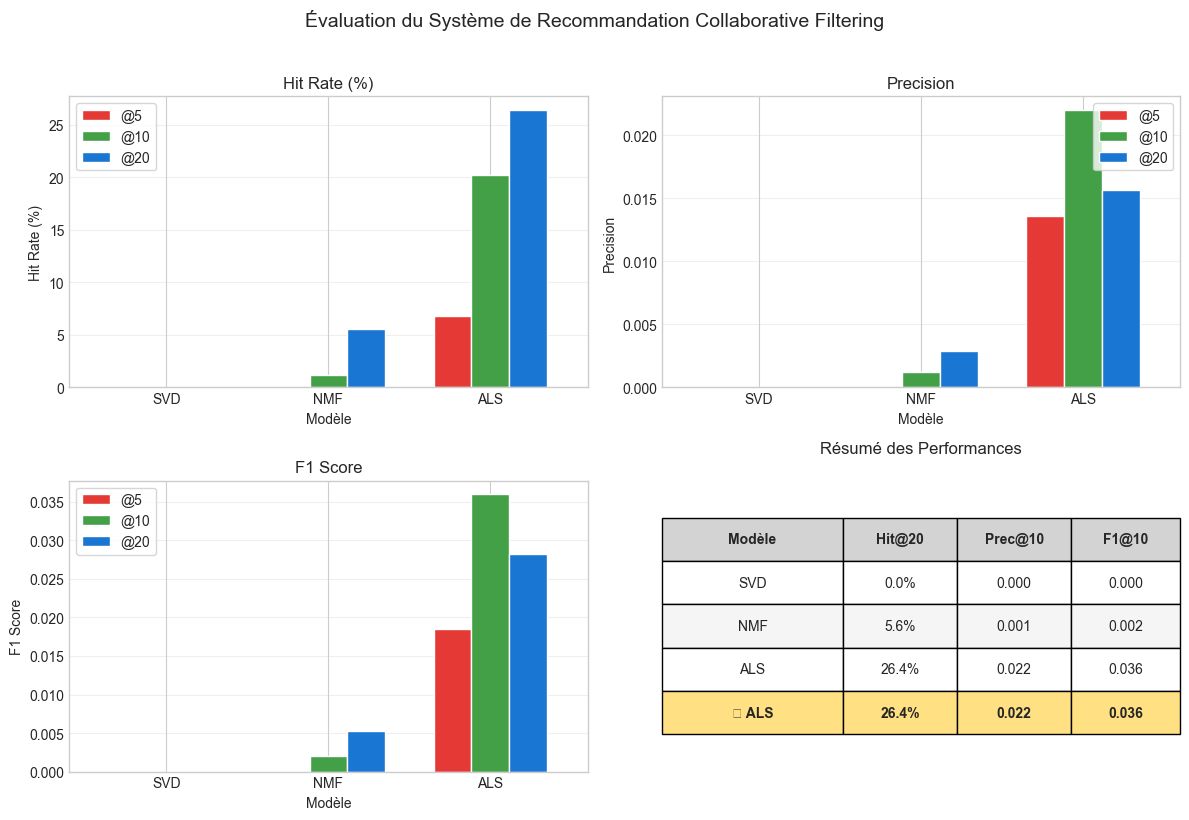

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Préparation des données
comparison_df = pd.DataFrame(models_results).T

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#E53935', '#43A047', '#1976D2']

# Création de la figure avec 4 graphiques au lieu de 6
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Évaluation du Système de Recommandation Collaborative Filtering', fontsize=14, y=1.02)

# 1. Hit Rate comparison
ax1 = plt.subplot(2, 2, 1)
hit_data = comparison_df[['hit@5', 'hit@10', 'hit@20']] * 100
hit_data.plot(kind='bar', ax=ax1, color=colors, width=0.7)
ax1.set_title('Hit Rate (%)', fontsize=12)
ax1.set_xlabel('Modèle')
ax1.set_ylabel('Hit Rate (%)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(['@5', '@10', '@20'], frameon=True, loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# 2. Precision comparison
ax2 = plt.subplot(2, 2, 2)
precision_data = comparison_df[['precision@5', 'precision@10', 'precision@20']]
precision_data.plot(kind='bar', ax=ax2, color=colors, width=0.7)
ax2.set_title('Precision', fontsize=12)
ax2.set_xlabel('Modèle')
ax2.set_ylabel('Precision')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(['@5', '@10', '@20'], frameon=True, loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# 3. F1 Scores
ax3 = plt.subplot(2, 2, 3)
f1_scores = pd.DataFrame()
for k in [5, 10, 20]:
    precision = comparison_df[f'precision@{k}']
    recall = comparison_df[f'recall@{k}']
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    f1_scores[f'@{k}'] = f1

f1_scores.plot(kind='bar', ax=ax3, color=colors, width=0.7)
ax3.set_title('F1 Score', fontsize=12)
ax3.set_xlabel('Modèle')
ax3.set_ylabel('F1 Score')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend(frameon=True, loc='upper left')
ax3.grid(axis='y', alpha=0.3)

# 4. Tableau récapitulatif
ax4 = plt.subplot(2, 2, 4)
ax4.axis('tight')
ax4.axis('off')

# Préparer les données du tableau
table_data = []
for model in comparison_df.index:
    row = [
        model,
        f"{comparison_df.loc[model, 'hit@20']:.1%}",
        f"{comparison_df.loc[model, 'precision@10']:.3f}",
        f"{f1_scores.loc[model, '@10']:.3f}"
    ]
    table_data.append(row)

# Ajouter la ligne du meilleur modèle
best_model = f1_scores['@10'].idxmax()
winner_row = [
    f"🏆 {best_model}",
    f"{comparison_df.loc[best_model, 'hit@20']:.1%}",
    f"{comparison_df.loc[best_model, 'precision@10']:.3f}",
    f"{f1_scores.loc[best_model, '@10']:.3f}"
]
table_data.append(winner_row)

# Créer le tableau
table = ax4.table(cellText=table_data,
                colLabels=['Modèle', 'Hit@20', 'Prec@10', 'F1@10'],
                cellLoc='center',
                loc='center',
                colWidths=[0.35, 0.22, 0.22, 0.21])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style du tableau
for i in range(len(table_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#D3D3D3')
            cell.set_text_props(weight='bold')
        elif i == len(table_data):
            cell.set_facecolor('#FFE082')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('#F5F5F5' if i % 2 == 0 else 'white')

ax4.set_title('Résumé des Performances', fontsize=12, pad=20)

plt.tight_layout()
plt.show()
